filename: minianalysis__models_run_on_last_year_vs_next_year.py

description: 
    last updated: 6/13/2014
    Run model on last year of data used vs. next available year of data, as long as it is within a provided bound    
    
inputs:

outputs:

@author: Misha


In [14]:
from __future__ import division

import matplotlib.pyplot as plt

import pandas as pd
import pickle

import sys
sys.path.append('../')    
import GSSUtility as GU

import numpy as np
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict

import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

In [47]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

<module 'GSSUtility' from '../GSSUtility.py'>

In [51]:
custom_data = pd.read_csv('../../Data/juliana/1533/1533_1977.csv', index_col=0)  
custom_data.columns = map(str.upper, custom_data.columns)

custom_data = custom_data.replace({'.i':np.nan, 'dk,na,iap':np.nan})

In [52]:
custom_data.astype(float) # doesn't work because stata has files in numerical and string formats, unlike the file I used which was all numerical

ValueError: could not convert string to float: english

In [49]:
#*********************************************************
allPropsForYearsUsed = []
allPropsForYearsPossible =[]
allParamSizesForYearsUsed = []
allParamSizesForYearsPossible = []
allRsForYearsUsed, allRsForYearsPossible = [], []

 
############################################################
if __name__ == "__main__":    

    try:
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass


    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=False, \
                                        centralIVs=False, nextYearBound=0, linearModels=False)            
    print 'len of articleClasses:', len(articlesToUse)
#     raw_input('...')
    
    
    # define the storage containers for outputs
    group1 = 'on last GSS year'
    group2 = 'on first "future" GSS year'   
    groups = [group1, group2]
    outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
                'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for group in groups:
        for outcome in outcomes:
            output[group][outcome] = []
    
#     log=open('log_file.txt', 'w')       
#     for article in random.sample(articlesToUse, 200):
#     for article in None: #articlesToUse:
    
    
    article = [a for a in articlesToUse if a.articleID == 1533][0]
    
    print '\n===================\nProcessing article:', article.articleID

    RHS = article.IVs + article.controls

    dfoutput = pd.DataFrame(index=article.DVs, columns=outcomes)

    for DV in article.DVs:
#             print DV, '~', RHS
        maxYearUsed = max(article.GSSYearsUsed)
        futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]
        nextYear = min(futureYearsPossible) # the arguments of GU.filterArticles function ensure that there is a suitable future year (within bound)

#             log.write('id'+str(article.articleID)+' year '+str(maxYearUsed))

        resOnDataUsed = GU.runModel(dataCont, maxYearUsed, DV, RHS, custom_data=custom_data); # models run on max year of data used
        if not resOnDataUsed: continue

# #             log.write('id'+str(article.articleID)+' year '+str(nextYear))           
#         resOnNextYear = GU.runModel(dataCont, nextYear, DV, RHS); # models run on min year of future data
#         if not resOnNextYear: continue

#         # Checks on which results to record                
#         if len(resOnDataUsed.params) != len(resOnNextYear.params):
#             print 'The number of variables in original model is different from the number in model on future years. Skipping.'                    
#             continue

        # the condition below means that i don't care about models in which orig var isn't stat. sig.
#            if results.pvalues[-1] > 0.05: continue
#         results = [resOnDataUsed, resOnNextYear]

        centralVars = []            
        for civ in article.centralIVs:
            if 'standardize(%s)' % (civ) in resOnDataUsed.params.index:
                centralVars.append('standardize(%s)' % (civ))
            else: 
                for col in resOnDataUsed.params.index:
                    if 'C(' + civ + ')' in col:
                        centralVars.append(col)

#             print 'IVs:', article.IVs
#             print 'centralVas:', centralVars
#            raw_input('...')
        '''                
        centralVars = ['standardize(%s, ddof=1)' % (cv) for cv in article.centralIVs]
        centralVars = set(centralVars).intersection(results[0].params.index) # need this step because some central                                                                                            # var columns may be removed when running model
        '''

        dfoutput.loc[DV, 'Rs'] = resOnDataUsed.rsquared
        dfoutput.loc[DV, 'adjRs'] = resOnDataUsed.rsquared_adj
        dfoutput.loc[DV, 'propSig'] = float(len([p for p in resOnDataUsed.pvalues[1:] if p < 0.05]))/len(resOnDataUsed.params[1:]) 
        dfoutput.loc[DV, 'paramSizesNormed'] = np.mean(resOnDataUsed.params[1:].abs()) 
        dfoutput.loc[DV, 'pvalues'] = np.mean( resOnDataUsed.pvalues[1:])
        dfoutput.loc[DV, 'numTotal'] = 1  #divide by len of R^2 array to get a mean of variables estimated PER model                           

        if len(centralVars)>0:
            dfoutput.loc[DV, 'pvalues_CentralVars'] = np.mean(resOnDataUsed.pvalues[centralVars])
            dfoutput.loc[DV, 'propSig_CentralVars'] = float(len([p for p in resOnDataUsed.pvalues[centralVars] if p < 0.05])) \
                                                    /len(resOnDataUsed.params[centralVars]) 
            dfoutput.loc[DV, 'paramSizesNormed_CentralVars'] = np.mean(resOnDataUsed.params[centralVars].abs())                
        else:
            dfoutput.loc[DV, 'pvalues_CentralVars'] = np.nan
            dfoutput.loc[DV, 'propSig_CentralVars'] = np.nan
            dfoutput.loc[DV, 'paramSizesNormed_CentralVars'] = np.nan

#         output['metadata']['article_id'].append(article.articleID)                 

   
# pickle.dump(output, open('output.pickle', 'w'))    
#     print 'TTests'
#     for outcome in outcomes:
#         print 'Means of group1 and group2:', np.mean(output[group1][outcome]), np.mean(output[group2][outcome]), 'Paired T-test of ' + outcome, ttest_rel(output[group1][outcome], output[group2][outcome])


len of articleClasses: 769

Processing article: 1533


ValueError: could not convert string to float: dk

In [22]:
dfoutput

,propSig,paramSizesNormed,Rs,adjRs,pvalues,numTotal,propSig_CentralVars,paramSizesNormed_CentralVars,pvalues_CentralVars
ABDEFECT,0.2307692,0.1167138,0.03862152,0.03037751,0.3442292,1,0,0.1594412,0.3638964
ABNOMORE,0.6153846,0.267502,0.08400313,0.07614827,0.08828286,1,0.625,0.392415,0.06776418
ABRAPE,0.3846154,0.1155748,0.06054659,0.05249059,0.2987954,1,0.125,0.1423033,0.4657144
ABPOOR,0.6153846,0.1749821,0.06574673,0.05773532,0.2119849,1,0.625,0.2452529,0.2272282
ABSINGLE,0.8461538,0.2329319,0.08239397,0.07452531,0.07710254,1,0.75,0.3245365,0.1216171
ABHLTH,0.2307692,0.08078577,0.03391164,0.02562724,0.4129616,1,0,0.09993141,0.5773045
PREMARSX,0.5384615,0.2457712,0.1582109,0.1509924,0.2395944,1,0.625,0.3439428,0.1472253
XMARSEX,0.8461538,0.3502316,0.07679742,0.06888077,0.1302499,1,1,0.5284226,0.005637058
HOMOSEX,0.7692308,0.302848,0.1362959,0.1288895,0.07433719,1,0.75,0.4228202,0.1015658
SPKATH,0.5384615,0.2215509,0.2292363,0.2226268,0.1496478,1,0.375,0.2814371,0.2014111


Create dataframe that contains the output 
--

In [67]:
output = pickle.load(open('output.pickle'))
group1 = 'on last GSS year'
group2 = 'on first "future" GSS year'   
groups = [group1, group2]
outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
            'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

In [68]:
df_output = pd.DataFrame(index=np.arange(len(output[group1]['propSig'])), columns=pd.MultiIndex.from_product([groups, outcomes]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[gp, outcome] = output[gp][outcome]
df_output['article_id'] = output['metadata']['article_id']
del df_output[group1, 'numTotal']
del df_output[group2, 'numTotal']
df_output.head()
# df_output.to_pickle('df_output.pickle')
# df_output

outcomes.remove('numTotal')

print 'Number of unique articles used:', len(df_output['article_id'].unique())

Number of unique articles used: 398


In [69]:
# if using another, non-ipython notebook method of running the code
# load in the output of that other method, and set up the relevant variables
# df_output = pd.read_pickle('df_output.pickle')
# group1 = 'on last GSS year'
# group2 = 'on first "future" GSS year'   
# groups = [group1, group2]
# outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
#             'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

Plot the output
--

In [70]:
# %matplotlib inline

# outcomesToUse = df_output[group1].columns
# indices = np.arange(len(outcomesToUse))
# width = 0.35
# axes = plt.figure(figsize=(12,8)).add_subplot(111)
# error_config = {'ecolor': '0.3'}
# rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='r', 
#                  yerr=df_output[group1].std()/np.sqrt(len(df_output[group1])), error_kw=error_config) 
# rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='y', 
#                  yerr=df_output[group2].std()/np.sqrt(len(df_output[group2])), error_kw=error_config)

# # title, legend, etc
# plt.title('Models Using Last GSS Year vs. First "Future" Year', fontsize=18)
# plt.legend((rects1[0], rects2[0]), ('Last Yr.', '1st Future Yr.'), fontsize=15)
# plt.xlim((-1*width, len(outcomesToUse)))

# # tick labels
# # a = outcomesToUse
# a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
#      '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
# axes.set_xticks(indices+width)
# axes.set_xticklabels(a, rotation=90, fontsize=15)

# # label the bars with the difference between them
# diffs = (df_output[group1] - df_output[group2]).mean().values
# def autolabel(rects):
#     # attach some text labels
#     for i, rect in enumerate(rects):
#         height = rect.get_height()
#         if i!=7 and i!=4:
#             axes.text(rect.get_x()+width, 1.02*height, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
#         else: # this is for the p-value label, which has gone up
#             axes.text(rect.get_x()+width, 1.02*height+0.05, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
# autolabel(rects1)

# # savefig('../../Images/ASA2015/models_using_last_gss_year_vs_first_future_year.png', bbox_inches='tight')

In [77]:
print outcomesToUse
print 
print diffs
print
print diffs_strings

[u'adjRs', u'Rs', u'paramSizesNormed_CentralVars', u'propSig_CentralVars', u'paramSizesNormed', u'propSig']

[-7.38366232 -6.82527713 -5.02303849 -4.37384316 -4.28664636 -3.06144311]

['(0.073 - 0.068)', '(0.080 - 0.075)', '(0.162 - 0.154)', '(0.433 - 0.414)', '(0.160 - 0.153)', '(0.428 - 0.415)']


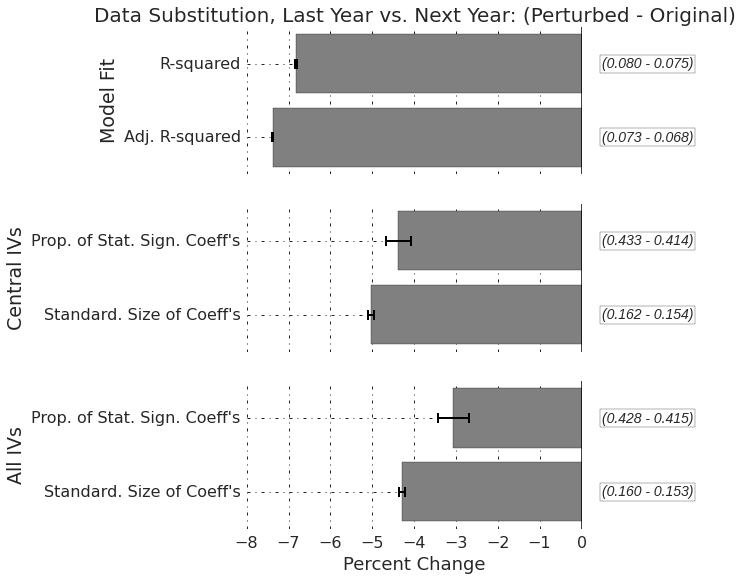

In [74]:
%matplotlib inline

# fig = plt.figure(figsize=(6,9))
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed',
                 u'propSig']

outcomeMap = {'propSig':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}

# indices = [1,2,4,5,7,8]
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)

diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group1, outcome].mean(), df_output[group2, outcome].mean()) 
                 for outcome in outcomesToUse]
diffs = np.array(diffs)

# naive SES
# ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# clustered SES
clusteredSES = []
article_ids = np.array(list(df_output.index)) 
for outcome in outcomesToUse:
    diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mask = ~np.isnan(np.array(diff))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
    clusteredSES.append(result_clustered.HC0_se[0])
clusteredSES = np.array(clusteredSES)

colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
    xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)

    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + .5 # the indices here mean get the x-coord of 2nd box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + .5

    axarr[i].text(box0_xcoord, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)        
    
axarr[0].set_title('Data Substitution, Last Year vs. Next Year: (Perturbed - Original)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('All IVs', fontsize=19)
axarr[2].set_xlabel('Percent Change', fontsize=18)
plt.xticks(fontsize=16)
# plt.xlim(-10, 50)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

plt.savefig('images/last-vs-next--original-minus-perturbed.svg', bbox_inches='tight', dpi=150)

Perform t-tests
--

In [ ]:
# import rpy2.robjects as robjects
# import pandas.rpy.common as com
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# r = robjects.r

# article = articlesToUse[10]
# mydf = dataCont.df.loc[1974, article.DVs+article.IVs]
# mydf.head()

In [16]:
# # (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

# from scipy.stats import ttest_1samp
# for outcome in outcomes:
#     print outcome
#     print 'mean group 1', df_output[group1, outcome].mean()
#     print 'mean group 2', df_output[group2, outcome].mean()
#     print ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1]
#     print

Perform t-tests and Tests using *clustered errors*
--

1. Perform related-sample t-test (samples must be of equal lengths)

2. Perform independent samples t-test (just for kicks, to see how big our effects are)

3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html

Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Note
--
For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.

Outcome
--
The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?


In [17]:
# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', np.around(df_output[group1, outcome].mean(), 3)
    print 'Mean after substitution:', np.around(df_output[group2, outcome].mean(), 3)
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                            cov_kwds=dict(groups=df_output.article_id))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'Clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

propSig
Mean before substitution: 0.475
Mean after substitution: 0.477
Related samples t-test p-value: 0.731899
Clustered errors p-value: 0.803

paramSizesNormed
Mean before substitution: 0.167
Mean after substitution: 0.162
Related samples t-test p-value: 0.001963
Clustered errors p-value: 0.058

Rs
Mean before substitution: 0.094
Mean after substitution: 0.091
Related samples t-test p-value: 9.6e-05
Clustered errors p-value: 0.003

adjRs
Mean before substitution: 0.088
Mean after substitution: 0.085
Related samples t-test p-value: 0.000476
Clustered errors p-value: 0.007

pvalues
Mean before substitution: 0.23
Mean after substitution: 0.232
Related samples t-test p-value: 0.69056
Clustered errors p-value: 0.768

propSig_CentralVars
Mean before substitution: 0.479
Mean after substitution: 0.483
Related samples t-test p-value: nan


ValueError: The weights and list don't have the same length.

How many models' avg p-value is above 0.05?
--

In [ ]:
# # need to see tally up how switched from being below to being above
# # i.e. need to condition on being below beforehand, and how many of those are above now

# print 'count:', df_output[group2]['pvalues'][df_output[group2]['pvalues'] > 0.05].shape[0]
# print 'total:', df_output.shape[0]
# print 'percent:', df_output[]['pvalues'][df_output['cognate models']['pvalues'] > 0.05].shape[0]/ df_output.shape[0]